In [1]:
import mlflow
import mlflow.sklearn
import pandas as pd
from numpy import savetxt, select
from sklearn.datasets import load_diabetes
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from pprint import pprint
from mlflow import log_metric, log_param, log_artifacts

from sklearn.metrics import make_scorer, f1_score, recall_score,precision_score, get_scorer_names, accuracy_score,confusion_matrix, roc_curve
from mlflow import log_metric, log_param, log_artifacts

import seaborn as sn
import matplotlib.pyplot as plt

import joblib

from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification



# Read data

In [2]:
fraudes_df = pd.read_csv('datos_regiones_especiales_201906-202205.csv').drop(['grupo','NombreRegion'],axis=1)#.drop(['LOCALIDAD','MUNICIPIO'], axis = 1)

fraudes_df['fraude'] = fraudes_df['fraude'].replace(1,-1).replace(0,1)
#fraudes_df = pd.merge(fraudes_df, actividad_econ_df,how='inner', on = ['nis_rad']).drop('Unnamed: 0', axis=1)
fraudes_df.head()

,LlavePuntoConsumo,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,202204,202205,AlturaPuntoConsumo,NombreDepartamentoGeografia,NombreMunicipioGeografia,seccion,DescripcionAnomalia,anomalias_anuales,fraude
0,1002467,122.72,111.53,113.11,97.14,102.40,95.17,121.67,125.47,133.44,114.80,124.71,123.69,1784.0,CHIMALTENANGO,CHIMALTENANGO,Residenciales,NO REGSITRADO,0,-1
1,1017184,0.00,3.15,10.46,114.57,1.01,1.90,1.05,0.95,0.00,0.00,0.00,0.00,1779.0,CHIMALTENANGO,SAN MARTIN JILOTEPEQUE,Residenciales,Presunto Fraude,0,-1
2,2405770,111.18,147.18,161.90,236.47,344.72,323.79,90.20,81.74,122.65,171.71,270.71,245.36,2530.0,SOLOLA,SANTA LUCIA UTATLAN,Residenciales,NO REGSITRADO,0,-1
3,2442128,58.87,62.93,94.19,294.35,227.11,207.21,205.57,212.92,238.58,219.00,255.50,208.99,2033.0,QUICHE,SANTA CRUZ DEL QUICHE,Residenciales,NO REGSITRADO,0,-1
4,3161851,25.51,13.64,2.94,11.41,11.54,13.31,23.07,27.57,39.25,37.51,42.58,41.21,921.0,SANTA ROSA,CUILAPA,Residenciales,Tapa rota/falta,0,-1


## Data processing

### Handle categoricals

In [3]:
ohe_features = fraudes_df


In [4]:
ohe_NombreDepartamentoGeografia = OneHotEncoder()
ohe_NombreMunicipioGeografia = OneHotEncoder()
ohe_seccion = OneHotEncoder()
ohe_DescripcionAnomalia = OneHotEncoder()

transformed_NombreDepartamentoGeografia = ohe_NombreDepartamentoGeografia.fit_transform(ohe_features[['NombreDepartamentoGeografia']])
ohe_features[ohe_NombreDepartamentoGeografia.categories_[0]] = transformed_NombreDepartamentoGeografia.toarray()

transformed_NombreMunicipioGeografia = ohe_NombreMunicipioGeografia.fit_transform(ohe_features[['NombreMunicipioGeografia']])
ohe_features[ohe_NombreMunicipioGeografia.categories_[0]] = transformed_NombreMunicipioGeografia.toarray()

transformed_seccion = ohe_seccion.fit_transform(ohe_features[['seccion']])
ohe_features[ohe_seccion.categories_[0]] = transformed_seccion.toarray()

transformed_DescripcionAnomalia = ohe_DescripcionAnomalia.fit_transform(ohe_features[['DescripcionAnomalia']])
ohe_features[ohe_DescripcionAnomalia.categories_[0]] = transformed_DescripcionAnomalia.toarray()

ohe_features = ohe_features.drop(['NombreDepartamentoGeografia','NombreMunicipioGeografia','seccion','DescripcionAnomalia'], axis = 1)

/tmp/ipykernel_92/498564259.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohe_features[ohe_NombreMunicipioGeografia.categories_[0]] = transformed_NombreMunicipioGeografia.toarray()
/tmp/ipykernel_92/498564259.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohe_features[ohe_NombreMunicipioGeografia.categories_[0]] = transformed_NombreMunicipioGeografia.toarray()
/tmp/ipykernel_92/498564259.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

In [5]:
y = ohe_features['fraude']

X = ohe_features



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.drop(['fraude','LlavePuntoConsumo'], axis = 1)

nis_x_test = X_test['LlavePuntoConsumo']

X_test = X_test.drop(['fraude','LlavePuntoConsumo'], axis = 1)
                      
X_test_full = X_test

In [14]:
X_train.head()

,202106,202107,202108,202109,202110,202111,202112,202201,202202,202203,...,Medidor sin Precinto en Bornera,NO REGSITRADO,No se ubica el suministro,Num.med. no coincide,Numero de Medidor c/Dem. no Coincide,Observaciones,Presunto Fraude,Presunto Fraude > 11kW,Tapa rota/falta,Vidrio Med. sin marchamo
25608,3.04,3.92,1.96,3.04,2.03,2.94,5.07,2.94,5.89,5.24,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26254,39.86,76.04,57.89,68.68,67.49,66.08,34.61,99.80,52.72,49.68,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34771,55.59,29.44,35.49,38.97,70.65,46.15,34.61,36.12,38.53,27.38,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29498,60.83,50.04,46.64,56.08,53.97,56.64,50.34,55.13,47.65,53.97,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41407,70.27,69.96,69.66,60.83,76.99,66.08,65.03,55.93,52.98,58.81,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:



def yield_artifacts(run_id, path=None):
    """Yield all artifacts in the specified run"""
    client = mlflow.tracking.MlflowClient()
    for item in client.list_artifacts(run_id, path):
        if item.is_dir:
            yield from yield_artifacts(run_id, item.path)
        else:
            yield item.path


def fetch_logged_data(run_id):
    """Fetch params, metrics, tags, and artifacts in the specified run"""
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    # Exclude system tags: https://www.mlflow.org/docs/latest/tracking.html#system-tags
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = list(yield_artifacts(run_id))
    return {
        "params": data.params,
        "metrics": data.metrics,
        "tags": tags,
        "artifacts": artifacts,
    }



2022/10/28 06:59:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '41d16168a3b040099c4f328f14724e1c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/28 07:05:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2022/10/28 07:05:59 INFO mlflow.sklearn.utils: Logging the 5 best runs, 155 runs will be omitted.


========== parent run ==========

---------- logged params ----------
{'best_contamination': '0.4',
 'best_max_features': '5',
 'best_max_samples': '450',
 'best_n_estimators': '100',
 'best_n_jobs': '-1',
 'cv': '5',
 'error_score': 'nan',
 'estimator': 'IsolationForest()',
 'n_jobs': 'None',
 'param_grid': "{'n_jobs': [-1], 'n_estimators': (100, 200), 'max_features': "
               "[5, 2], 'max_samples': [100, 150, 200, 250, 300, 350, 400, "
               "450], 'contamination': [0.1, 0.2, 0.3, 0.4, 0.5]}",
 'pre_dispatch': '2*n_jobs',
 'refit': 'True',
 'return_train_score': 'True',
 'scoring': 'make_scorer(f1_score, average=micro)',
 'verbose': '0'}

---------- logged metrics ----------
{'best_cv_score': 0.6897266964789649, 'training_score': 0.6267491926803014}

---------- logged tags ----------
{'estimator_class': 'sklearn.model_selection._search.GridSearchCV',
 'estimator_name': 'GridSearchCV'}

---------- logged artifacts ----------
['best_estimator/MLmodel',
 'best_estimato

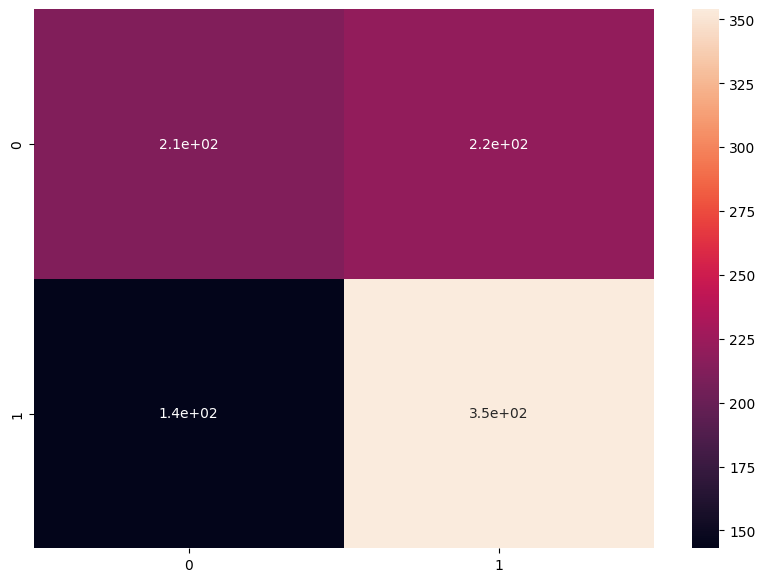

In [7]:
mlflow.set_experiment("Energuate-Regiones-especiales-supervisado")

def main():
    mlflow.sklearn.autolog()

    
    parameters = {"n_jobs":[-1], "n_estimators": (100,200), "max_features": [5,2],'max_samples': list(range(100, 500, 50)),'contamination': [0.1, 0.2, 0.3, 0.4, 0.5]}
    f1sc = make_scorer(f1_score, average='micro')
    is_fr = IsolationForest()
    clf = GridSearchCV(is_fr, parameters, scoring=f1sc, cv = 5,return_train_score=True,refit=True)

    
    clf.fit(X_train.values, y_train.values)
    run_id = mlflow.last_active_run().info.run_id

    # show data logged in the parent run
    print("========== parent run ==========")
    for key, data in fetch_logged_data(run_id).items():
        print("\n---------- logged {} ----------".format(key))
        pprint(data)

    # show data logged in the child runs
    filter_child_runs = "tags.mlflow.parentRunId = '{}'".format(run_id)
    runs = mlflow.search_runs(filter_string=filter_child_runs)
    param_cols = ["params.{}".format(p) for p in parameters.keys()]
    metric_cols = ["metrics.mean_test_score"]

    print("\n========== child runs ==========\n")
    pd.set_option("display.max_columns", None)  # prevent truncating columns
    print(runs[["run_id", *param_cols, *metric_cols]])

    with mlflow.start_run(run_id=run_id) as run:
        print('---TEST_METRICS----')
        
        y_pred = clf.predict(X_test.values)
        y_true = y_test.values
        print(y_pred)
        print(y_true)
        f1 = f1_score(y_true, y_pred, average='binary')
        log_metric("test_f1_score", f1)
        print('test_score_f1 '+str(f1))
        recall = recall_score(y_true, y_pred, average='binary')
        log_metric("test_recall_score", recall)
        print('test_recall_f1 '+str(recall))
        accuracy = accuracy_score(y_true, y_pred)
        log_metric("test_accuracy_score", accuracy)
        print('test_score_accuracy '+str(accuracy))
        precision = precision_score(y_true, y_pred)
        log_metric("test_precision_score", precision)
        print('test_score_precision '+str(precision))
        #log_param("estimator", "IsolationForest")
        
        test_cfm = confusion_matrix(y_true, y_pred)
        df_cfm = pd.DataFrame(test_cfm, index = ["0", "1"], columns = ["0", "1"])
        plt.figure(figsize = (10,7))
        cfm_plot = sn.heatmap(df_cfm, annot=True)
        cfm_plot.figure.savefig("cfm_test.png")
        print(test_cfm)
        mlflow.log_artifact("cfm_test.png")
        
        
        
if __name__ == "__main__":
    main()

In [ ]:
def main():
   
    with mlflow.start_run():
        parameters = {"n_jobs":[-1], "n_estimators": (100,200), "max_features": [5,2],'max_samples': list(range(100, 500, 5)),'contamination': [0.1, 0.2, 0.3, 0.4, 0.5]}
        f1sc = make_scorer(f1_score, average='micro')
        is_fr = IsolationForest()
        clf_grid = GridSearchCV(is_fr, parameters, scoring=f1sc, cv = 5,return_train_score=True,refit=True)

        clf_grid.fit(df_data, y_true)
    
    
    
        run_id = mlflow.last_active_run().info.run_id
        print("Run ID: "+run_id)
        print(" Results from Grid Search " )
        print("\n The best estimator across ALL searched params:\n",clf_grid.best_estimator_)
        print("\n The best score across ALL searched params:\n",clf_grid.best_score_)
        print("\n The best parameters across ALL searched params:\n",clf_grid.best_params_)
        
        log_metric("best_cv_f1_score", clf_grid.best_score_)
        
        mlflow.sklearn.log_model(clf_grid.best_estimator_, "ISFmodel")
        for key in bpr:
            log_param(key, bpr[key])
            print(key,bpr[key])
    
    mlflow.end_run()
    


if __name__ == "__main__":
    main()

In [ ]:
import itertools

for t in itertools.product(*iterables):
    print(t)


(5, 100, -1)
(5, 200, -1)
(5, 300, -1)
(20, 100, -1)
(20, 200, -1)
(20, 300, -1)
(50, 100, -1)
(50, 200, -1)
(50, 300, -1)


 Results from Grid Search 
0.42060080262665595 0.416813205301725 0.416813205301725 0.416813205301725
{'mean_fit_time': array([0.33168495, 0.33833253, 0.33099961, 0.33302593]), 'std_fit_time': array([0.01221168, 0.01193321, 0.01324868, 0.02503109]), 'mean_score_time': array([0.11929989, 0.11898947, 0.13373029, 0.11685717]), 'std_score_time': array([0.00573635, 0.00026965, 0.00089538, 0.00046432]), 'param_bootstrap': masked_array(data=[True, True, False, False],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_features': masked_array(data=[5, 10, 5, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'bootstrap': True, 'max_features': 5}, {'bootstrap': True, 'max_features': 10}, {'bootstrap': False, 'max_features': 5}, {'bootstrap': False, 'max_features': 10}], 'split0_test_score': array([0.4517815 , 0.48536042, 0.34348739, 0.37722952]), 'split1_test_score': array([0

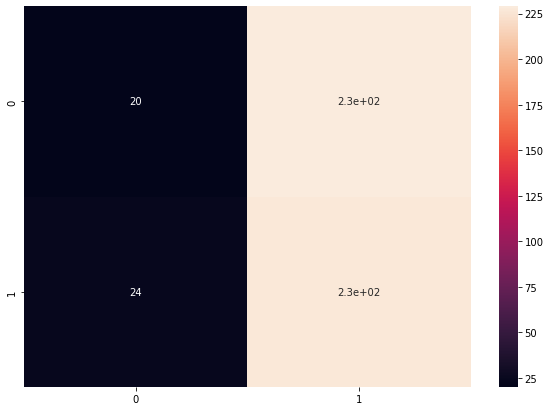

In [68]:


mlflow.set_experiment("IsolationForest-test")


clf = IsolationForest(random_state=47)

param_grid = {
              'max_features': [5,10], 
              'bootstrap': [True, False]}

f1sc = make_scorer(f1_score, average='binary')

grid_dt_estimator = model_selection.GridSearchCV(clf,
                                                 param_grid,
                                                 scoring='f1_macro', 
                                                 refit=True,
                                                 cv=2, 
                                                 return_train_score=True)
grid_dt_estimator.fit(X_train, y_train)


print(" Results from Grid Search " )
#print("\n The best estimator across ALL searched params:\n",grid_dt_estimator.best_estimator_)
#print("\n The best score across ALL searched params:\n",grid_dt_estimator.best_score_)
#print("\n The best parameters across ALL searched params:\n",grid_dt_estimator.best_params_)
#print(grid_dt_estimator.cv_results_['mean_train_f1_macro'])

mean_f1_train = grid_dt_estimator.cv_results_['mean_test_score'].mean()

#mean_f1_test = grid_dt_estimator.cv_results_['mean_train_f1_macro'].mean()

#mean_accuracy_train = grid_dt_estimator.cv_results_['mean_train_f1_macro'].mean()

#mean_accuracy_train = grid_dt_estimator.cv_results_['mean_train_f1_macro'].mean()

print(mean_f1_train,mean_f1_test,mean_accuracy_train,mean_accuracy_test)
print(grid_dt_estimator.cv_results_)
#be = grid_dt_estimator.best_estimator_
#bsc = grid_dt_estimator.best_score_
#bpr = grid_dt_estimator.best_params_
#print("\n The mean_train_f1_macro score across ALL searched params:\n",grid_dt_estimator.cv_results_.mean_train_f1_macro)
#print("\n The best score across ALL searched params:\n",grid_dt_estimator.best_score_)
#print("\n The best score across ALL searched params:\n",grid_dt_estimator.best_score_)

y_pred = grid_dt_estimator.predict(X_train)
y_true = y_train
print(y_pred)
print(y_true)
f1 = f1_score(y_true, y_pred, average='macro')
#log_metric("test_f1_score", f1)
print('test_score_f1 '+str(f1))
recall = recall_score(y_true, y_pred, average='macro')
#log_metric("test_recall_score", recall)
print('test_recall_f1 '+str(recall))
accuracy = accuracy_score(y_true, y_pred)
#log_metric("test_accuracy_score", accuracy)
print('test_score_accuracy '+str(accuracy))
    
test_cfm = confusion_matrix(y_true, y_pred)
df_cfm = pd.DataFrame(test_cfm, index = ["0", "1"], columns = ["0", "1"])
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True)
cfm_plot.figure.savefig("cfm_test.png")
print(test_cfm)
#mlflow.log_artifact("cfm_test.png")

#print(type(be))
#print(type(bsc))
#print(type(bpr))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Results from Grid Search 
335
True
{'mean_fit_time': array([0.6816153 , 0.97105193, 1.9659544 , 6.60134892, 4.98686481,
       1.17211533, 1.52589703, 2.34707079, 4.41023641, 5.07248826]), 'std_fit_time': array([0.02648197, 0.04564985, 0.90590166, 4.59679025, 0.70370384,
       0.30842613, 0.21630409, 0.2334381 , 0.16721062, 0.35364258]), 'mean_score_time': array([0.45105233, 0.70378757, 1.15737896, 2.00080209, 1.88728065,
       0.74631338, 1.14414225, 1.34938745, 1.85590158, 1.70869465]), 'std_score_time': array([0.01795787, 0.02675519, 0.29227508, 0.16576685, 0.17614331,
       0.0615181 , 0.30437558, 0.12654251, 0.19493548, 0.05761968]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, False, False, False,
                   False, False],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param

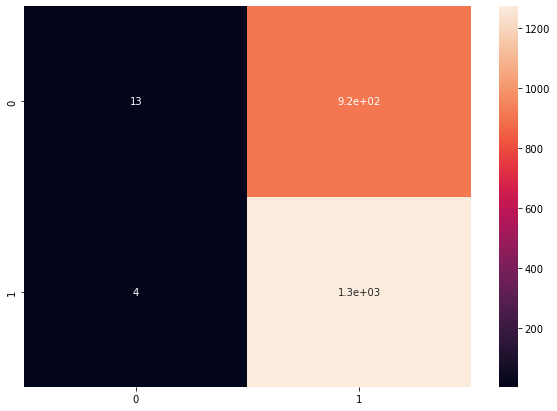

In [17]:
with mlflow.start_run():
    mlflow.set_experiment("IsolationForest-test")


    clf = IsolationForest(random_state=47)

    param_grid = {
              'max_features': [50,100,200,300,335], 
              'bootstrap': [True, False]
                
    }

    f1sc = make_scorer(f1_score, average='binary')

    grid_dt_estimator = model_selection.GridSearchCV(clf,
                                                 param_grid,
                                                 scoring='f1_macro', 
                                                 refit=True,
                                                 cv=5,
                                                 verbose=1,
                                                 return_train_score=True)
    grid_dt_estimator.fit(X_train, y_train)
    

    print(" Results from Grid Search " )
    
    best_max_fratures = grid_dt_estimator.best_params_['max_features']
    best_bootstraps = grid_dt_estimator.best_params_['bootstrap']

    print(grid_dt_estimator.best_params_['max_features'])
    log_param("best_max_features", best_max_fratures)

    print(grid_dt_estimator.best_params_['bootstrap'])
    log_param("best_bootstrap", best_bootstraps)

    
    
    mean_f1_train = grid_dt_estimator.cv_results_['mean_test_score'].mean()
    log_metric("mean_f1_train_cv", mean_f1_train)
    mean_train_score = grid_dt_estimator.cv_results_['mean_train_score'].mean()
    log_metric("mean_train_score_cv", mean_train_score)


    print(grid_dt_estimator.cv_results_)

    y_pred = grid_dt_estimator.predict(X_test)
    y_true = y_test
    print(y_pred)
    print(y_true)
    f1 = f1_score(y_true, y_pred, average='macro')
    log_metric("test_f1_score", f1)
    print('test_score_f1 '+str(f1))
    recall = recall_score(y_true, y_pred, average='macro')
    log_metric("test_recall_score", recall)
    print('test_recall_f1 '+str(recall))
    accuracy = accuracy_score(y_true, y_pred)
    log_metric("test_accuracy_score", accuracy)
    print('test_score_accuracy '+str(accuracy))
    
    test_cfm = confusion_matrix(y_true, y_pred)
    df_cfm = pd.DataFrame(test_cfm, index = ["0", "1"], columns = ["0", "1"])
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("cfm_test.png")
    print(test_cfm)
    mlflow.log_artifact("cfm_test.png")
    joblib.dump(grid_dt_estimator.best_estimator_, 'IF.pkl')
    mlflow.log_artifact('IF.pkl')
    #print(type(be))
    #print(type(bsc))
    #print(type(bpr))
    mlflow.end_run()

In [35]:
X_train, y_train = make_classification(n_samples=500, 
                                       n_classes=2)

y_train = select([y_train == 1, y_train == 0], [-1, 1], y_train)
y_train

array([-1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,  1,
        1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,
        1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,
        1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1, -1, -1, -1, -1,  1,
       -1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,
       -1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1, -1,
        1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1,
       -1, -1,  1, -1, -1